In [158]:
library("devtools")
library("tidyverse")
library("EnhancedVolcano")

In [159]:
all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/sb_dir/sb_acr_classification.no_exons.all_ACRs.classified.sorted.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    
number_cell_type_acrs <- all_acrs %>% 
    dplyr::group_by(ACR_Class) %>% 
    summarise(acr_per_ct = n())

Rows: 51387 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chr, acr_name, score
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [160]:
control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/control_bed/sb.bundle_sheath.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

Rows: 1949 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [161]:
fimo_output_tsv <- read_tsv("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/all_acrs/sb_fimo_output/fimo.tsv")
fimo_output_tsv <- fimo_output_tsv #%>% 
 #   separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
 #   separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 7907405 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): motif_id, motif_alt_id, sequence_name, strand, matched_sequence
dbl (5): start, stop, score, p-value, q-value

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [162]:
fimo_output <- fimo_output_tsv %>% 
    separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
    separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [163]:
cell_type_sepcific_acrs_contigency <- fimo_output %>% 
    dplyr::filter(ACR_Class != "broadly_accessible") %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(counts = n())

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.


In [164]:
head(fimo_output)

motif_id,motif_alt_id,ACR_number,ACR_Class,location,start,stop,strand,score,p-value,q-value,matched_sequence
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
MA1403.1,BPC5,scACR_39050,broadly_accessible,Chr07:59581630-59582131,2,31,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG
MA1403.1,BPC5,scACR_37730,companion_cells_sieve_elements,Chr07:4454547-4455048,2,31,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG
MA1403.1,BPC5,scACR_15797,broadly_accessible,Chr02:78287178-78287679,2,31,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG
MA1403.1,BPC5,scACR_39050,broadly_accessible,Chr07:59581630-59582131,4,33,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG
MA1403.1,BPC5,scACR_15797,broadly_accessible,Chr02:78287178-78287679,4,33,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG
MA1403.1,BPC5,scACR_37730,companion_cells_sieve_elements,Chr07:4454547-4455048,4,33,+,59,7.5e-19,1.65e-14,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAG


In [165]:
bundle_sheath_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "bundle_sheath") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [166]:
cell_type_sepcific_acrs_contigency_joined <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [167]:
cell_type_sepcific_acrs_contigency_w_log2 <- cell_type_sepcific_acrs_contigency_joined %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., bundle_sheath_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "bundle_sheath") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [168]:
head(cell_type_sepcific_acrs_contigency_w_log2)

motif_id,motif_alt_id.x,ACR_Class,counts,acr_per_ct,fraction_cts_acrs_w_motif,motif_alt_id.y,control_counts,fraction_control_w_motif,log2FoldChange,test_stat,p_val,adjusted_pval,motif_alt_id
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MA0001.2,AGL3,bundle_sheath,155,1949,0.07952796,AGL3,172,0.08825038,-0.15014035,0.88379205,0.347165167,0.447154707,AGL3.
MA0005.2,AG,bundle_sheath,113,1949,0.05797845,AG,115,0.05900462,-0.02531109,0.01754386,0.894625810,0.927390768,AG.
MA0008.3,HAT5,bundle_sheath,300,1949,0.15392509,HAT5,373,0.19138019,-0.31421313,7.91827637,0.004893787,0.010803771,HAT5.
MA0034.1,Gam1,bundle_sheath,216,1949,0.11082606,Gam1,249,0.12775782,-0.20511443,2.34193548,0.125932999,0.194871483,Gam1.
MA0054.1,myb.Ph3,bundle_sheath,58,1949,0.02975885,myb.Ph3,94,0.04822986,-0.69660786,8.52631579,0.003500476,0.008138606,myb.Ph3.
MA0082.1,squamosa,bundle_sheath,323,1949,0.16572601,squamosa,308,0.15802976,0.06860381,0.35657686,0.550413532,0.642149121,squamosa.


In [169]:
calculate_chi_square <- cell_type_sepcific_acrs_contigency_w_log2

In [170]:
calculate_chi_square_subset <- calculate_chi_square %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset.df <- as.data.frame(calculate_chi_square_subset)
row.names(calculate_chi_square_subset.df) <- calculate_chi_square_subset.df$motif_alt_id
res <- calculate_chi_square_subset.df[,2:3]

In [171]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
Zm00001d005892.,-1.0780738,3.942582e-183
Zm00001d049364.,-1.2782289,3.184199e-180
LEP.,-1.0762035,8.595353e-156
Zm00001d020267.,-1.3221940,1.437599e-151
ERF115.,-1.1264970,1.198020e-148
LOB.,-1.3716607,2.296748e-146
Zm00001d024324.,-1.2595984,1.117802e-139
ERF9.,-0.9938869,2.472958e-135
ERF5.,-1.0181473,1.682098e-131


Warning message:
"ggrepel: 67 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


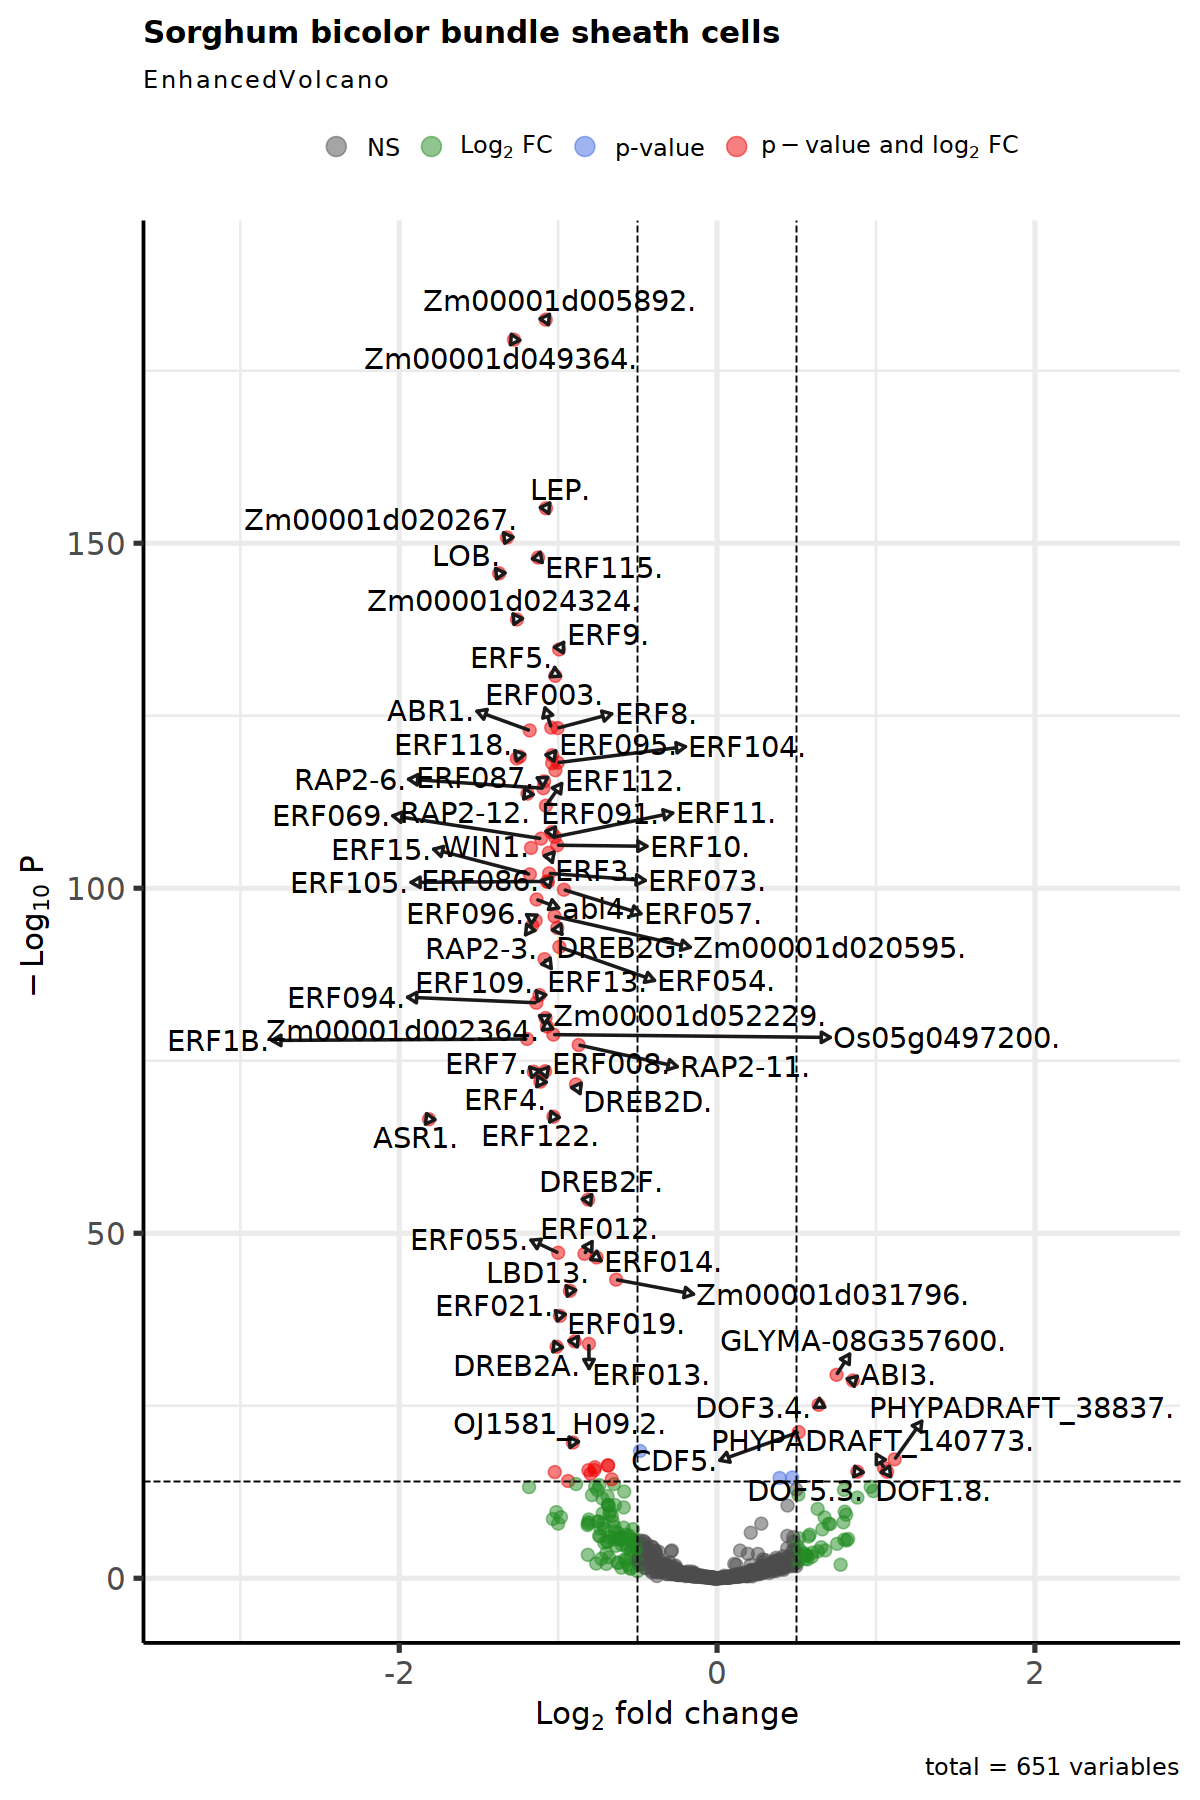

In [187]:
options(repr.plot.width=10, repr.plot.height=15)

EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Sorghum bicolor bundle sheath cells',
    pCutoff = 10e-15,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0, 
    drawConnectors = TRUE,
    widthConnectors = 0.75)

# Mesophyll Try

In [173]:
mesophyll_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/sb_dir/control_bed/sb.mesophyll.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

mesophyll_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% mesophyll_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "mesophyll") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

Rows: 2403 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [174]:
cell_type_sepcific_acrs_contigency_meso <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [175]:
cell_type_sepcific_acrs_contigency_w_log2_meso <- cell_type_sepcific_acrs_contigency_meso %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., mesophyll_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "mesophyll") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [176]:
calculate_chi_square_subset_meso <- cell_type_sepcific_acrs_contigency_w_log2_meso %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset_meso.df <- as.data.frame(calculate_chi_square_subset_meso)
row.names(calculate_chi_square_subset_meso.df) <- calculate_chi_square_subset_meso.df$motif_alt_id
res_meso <- calculate_chi_square_subset_meso.df[,2:3]

In [177]:
res_meso

,log2FoldChange,adjusted_pval
,<dbl>,<dbl>
AGL3.,-0.027350488,8.798256e-01
AG.,-0.176030364,4.069283e-01
HAT5.,-0.621731234,3.013874e-08
Gam1.,0.028196892,8.546187e-01
myb.Ph3.,-0.229025514,3.515248e-01
squamosa.,-0.011526253,9.299708e-01
bZIP910.,-0.053439259,8.382903e-01
bZIP911.,0.173064709,1.314962e-01
ATHB-5.,-0.486446760,6.987134e-04


In [178]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
Zm00001d005892.,-1.0780738,3.942582e-183
Zm00001d049364.,-1.2782289,3.184199e-180
LEP.,-1.0762035,8.595353e-156
Zm00001d020267.,-1.3221940,1.437599e-151
ERF115.,-1.1264970,1.198020e-148
LOB.,-1.3716607,2.296748e-146
Zm00001d024324.,-1.2595984,1.117802e-139
ERF9.,-0.9938869,2.472958e-135
ERF5.,-1.0181473,1.682098e-131


In [179]:
calculate_chi_square_subset %>% 
    filter(str_detect(motif_alt_id, "DOF"))

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
DOF2.5.,0.9837898,2.391466e-13
DOF1.8.,1.0700097,3.670108e-16
DOF2.4.,0.3711832,1.095408e-03
DOF5.6.,0.4420045,7.627700e-03
DOF5.7.,0.7115430,1.432625e-08
DOF5.3.,0.8828165,3.646086e-16
DOF5.8.,0.2784028,1.207324e-08
DOF4.5.,0.7013720,1.282866e-08
DOF3.2.,0.5114420,7.841187e-13


Warning message:
"ggrepel: 97 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


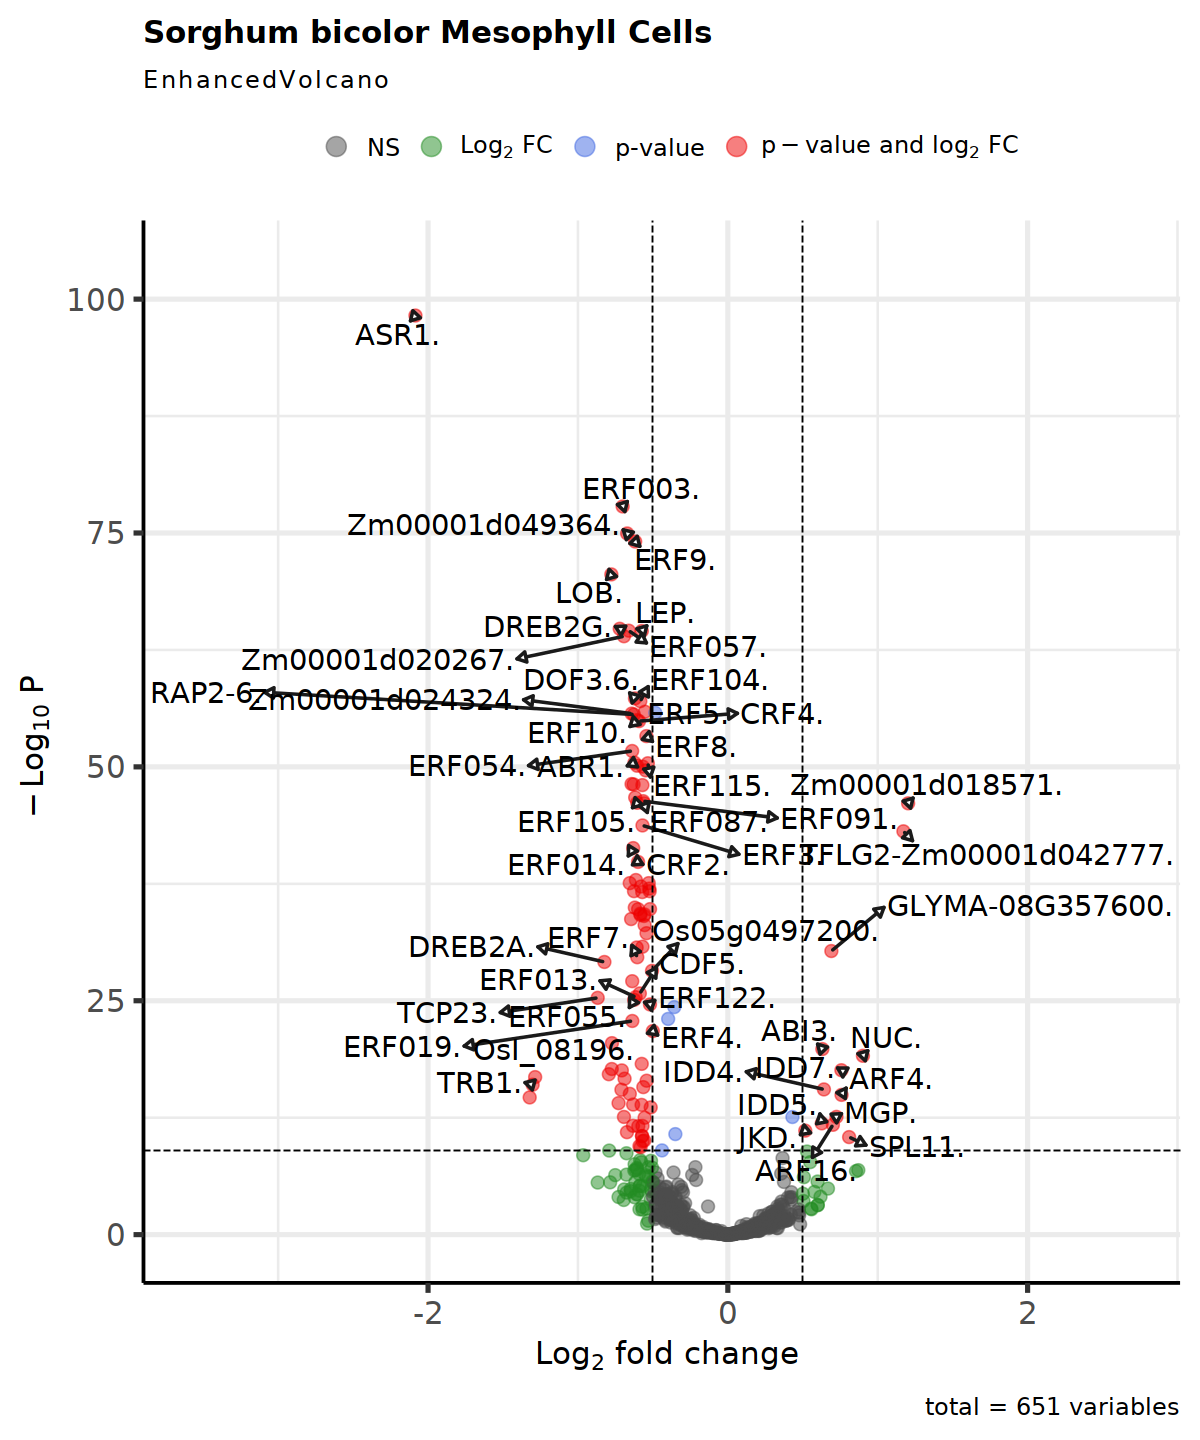

In [185]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res_meso,
    lab = rownames(res_meso),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Sorghum bicolor Mesophyll Cells',
    pCutoff = 10e-10,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)